# Live Tweet Analysis: Grande Fratello VIP

*“There is only one thing in the world worse than being talked about, and that is not being talked about.”* ― Oscar Wilde, The Picture of Dorian Gray

Episodes: 2021, December 17 + 2021, December 20

**GOAL**: Detect the most tweeted contestants of the Italian version of Celebrity Big Brother, **Grande Fratello VIP**, during the broadcast of the show, inside the official hashtag #GFVIP. Considering that the program airs twice during the week, the same analysis will be made for each of the two days.

**NOTES**:
* The show airs at 9.40 P.M. CET. The analysis will start before that moment.

## Required libraries

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.streaming import StreamingContext
from time import time
import datetime as dt
import string
import seaborn as sns
import matplotlib.pyplot as plt

## Variables

In [1]:
BATCH_DURATION = 5
PORT = 9999
hostname = "localhost"
checkpoint = "/home/daniel/checkpoint"
fig_cont_frid = "output/GFVIP_2021_12_17_cont.jpg"
fig_opin_frid = "output/GFVIP_2021_12_17_opin.jpg"
fig_cont_mond = "output/GFVIP_2021_12_19_cont.jpg"
fig_opin_mond = "output/GFVIP_2021_12_19_opin.jpg"

## Spark instance and Streaming Context

In [ ]:
sc = SparkContext()
ssc = StreamingContext(sc, BATCH_DURATION)
ssc.checkpoint(checkpoint)
lines = ssc.socketTextStream(hostname, PORT)

## Spark Session

In [ ]:
def get_spark_session(spark_context):
    if ("sqlContextSingletonInstance" not in globals()):
        globals()["sqlContextSingletonInstance"] = SparkSession \
                            .builder \
                            .config(conf=spark_context) \
                            .getOrCreate()
    return globals()["sqlContextSingletonInstance"]

## Data preprocessing

In [ ]:
def aggregate_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [ ]:
# Remove any hashtags and punctuation and make the word lowercase with the first letter uppercase
def clean_hashtag(word):
    return word.lower().capitalize().translate(str.maketrans('', '', string.punctuation))

In [ ]:
# Replace surnames or aliases with the names in the list
def change_name(name):
    if name in list(full_names.keys()):
        return full_names[name]
    else:
        return name

## Timestamp

In [ ]:
def format_timestamp(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
def print_timedelta(date_start):
    print("Start tweet analysis: " + format_timestamp(date_start))
    date_now = dt.datetime.now()
    print("Last update: " + format_timestamp(date_now))
    delta = date_now - date_start
    delta_seconds = delta.seconds
    delta_hours = delta_seconds/3600
    delta_minutes = (delta_seconds/60)%60
    delta_seconds = delta_seconds%60
    if delta.days!=0:
        print("Elapsed time: %d days, %d hours, %d minutes, %d seconds" 
                % (delta.days, delta_hours, delta_minutes, delta_seconds))
    else:
        print("Elapsed time: %d hours, %d minutes, %d seconds" 
                % (delta_hours, delta_minutes, delta_seconds))

## RDD processing

In [ ]:
def process_rdd(time, rdd):
    if (rdd.count()>0):
        spark = get_spark_session(rdd.context.getConf())
        row_rdd = rdd.map(lambda w: Row(Name=w[0], Count=w[1]))
        table_df = spark.createDataFrame(row_rdd)
        table_df = table_df.createOrReplaceTempView("TempView")

In [ ]:
def from_list_to_view(time, names_list, view_name):
    if (len(names_list)>0):
        names_rdd = sc.parallelize(names_list)
        spark = get_spark_session(names_rdd.context.getConf())
        row_rdd = names_rdd.map(lambda w: Row(Name=w))
        table_df = spark.createDataFrame(row_rdd)
        table_df = table_df.createOrReplaceTempView(view_name)

## Contestants, host and opinionists

List of contestants:
* Ainett Stephens
* **Aldo Montano**
* *Alessandro Basciano*: new contestant from Dec, 17
* Alex Belli
* Amedeo Goria
* Andrea Casalino
* *Barù*: new contestant from Dec, 20
* **Biagio D'Anelli**
* **Carmen Russo**
* Clarissa Hailé Selassié
* **Davide Silvestri**
* *Eva Grimaldi*: new contestant from Dec, 17
* *Federica Calemme*: new contestant from Dec, 17
* Francesca Cipriani
* **Giacomo Urtis**
* **Gianmaria Antinolfi**
* **Giucas Casella**
* **Jessica Hailé Selassié**
* Jo Squillo
* **Katia Ricciarelli**
* **Lucrezia "Lulù" Hailé Selassié**
* **Manila Nazzaro**
* **Manuel Bortuzzo**
* Maria Monsé
* **Miriana Trevisan**
* *Nathalie Caldonazzo*: new contestant from Dec, 20
* Nicola Pisu
* Patrizia Pellegrino
* Raffaella Fico
* Samy Youssef
* **Soleil Sorge**
* **Sophie Codegoni**
* Tommaso Eletti
* **Valeria Marini**

In [ ]:
contestants = ["Ainett","Aldo","Alessandro","Alex","Amedeo","Andrea","Barù","Biagio","Carmen","Clarissa","Davide",
               "Eva","Federica","Francesca","Giacomo","Gianmaria","Giucas","Jessica", "Jo","Katia","Lulù",
               "Manila","Manuel","Maria","Miriana","Nathalie","Nicola","Patrizia","Raffaella","Samy","Soleil",
               "Sophie","Valeria"]
from_list_to_view(time, contestants, "contestants_df")

List of opinionists and the host:
* **Alfonso Signorini**: host
* **Adriana Volpe**: opinionist
* **Sonia Bruganelli**: opinionist

In [ ]:
opinionists = ["Adriana", "Sonia", "Alfonso"]
from_list_to_view(time, opinionists, "opinionists_df")

Dictionary with surnames, nicknames, aliases.

In [ ]:
full_names = {"Stephens":"Ainett","Ainettstephens":"Ainett","Ainettstephens":"Ainett",
             "Montano":"Aldo","Aldomontano":"Aldo","Aldomontano0586":"Aldo",
             "Basciano":"Alessandro","Alessandrobasciano":"Alessandro",
             "Belli":"Alex","Alexbelli":"Alex","Belliproduction":"Alex",
             "Goria":"Amedeo","Amedeogoria":"Amedeo","Goriaamedeo":"Amedeo",
             "Casalino":"Andrea","Andreacasalino":"Andrea",
             "Gaetani":"Barù","Gherardo":"Barù","Baru":"Barù",
             "Danelli":"Biagio","Biagiodanelli":"Biagio",
             "Russo":"Carmen","Carmenrusso":"Carmen",
             "Silvestri":"Davide","Davidesilvestri":"Davide",
             "Grimaldi":"Eva","Evagrimaldi":"Eva","Evagrimaldi1":"Eva",
             "Calemme":"Federica","Federicacalemme":"Federica",
             "Cipriani":"Francesca","Francescacipriani":"Francesca","Cipri":"Francesca",
             "Antinolfi":"Gianmaria","Gianmariaantinolfi":"Gianmaria","Gianma":"Gianmaria",
             "Casella":"Giucas","Giucascasella":"Giucas",
             "Squillo":"Jo","Josquillo":"Jo",
             "Ricciarelli":"Katia","Katiaricciarelli":"Katia",
             "Nazzaro":"Manila","Manilanazzaro":"Manila",
             "Bortuzzo":"Manuel","Manuelbortuzzo":"Manuel","Manu":"Manuel",
             "Monsé":"Maria","Monsè":"Maria","Monse":"Maria","Mariamonse":"Maria",
             "Trevisan":"Miriana","Mirianatrevisan":"Miriana","Miri":"Miriana",
             "Caldonazzo":"Nathalie","Nathaliecaldonazzo":"Nathalie",
             "Pisu":"Nicola","Nicolapisu":"Nicola",
             "Pellegrino":"Patrizia","Patriziapellegrino":"Patrizia",
             "Fico":"Raffaella","Raffaellafico":"Raffaella",
             "Youssef":"Samy","Samyyoussef":"Samy",
             "Sorge":"Soleil","Soleilsorge":"Soleil","Soleilstasi":"Soleil",
             "Codegoni":"Sophie","Sophiecodegoni":"Sophie",
             "Marini":"Valeria","Valeriamarini":"Valeria","Valeriamarinivm":"Valeria",
             "Urtis":"Giacomo","Giacomourtis":"Giacomo",
             "Volpe":"Adriana","Adrianavolpe":"Adriana","Adri":"Adriana","Adrianavolpetv":"Adriana",
             "Bruganelli":"Sonia","Soniabruganelli":"Sonia","Sbruganelli":"Sonia",
             "Signorini":"Alfonso","Alfonsosignorini":"Alfonso","Alfosignorini":"Alfonso",
             "Alfo":"Alfonso","Alfi":"Alfonso"}

## Discretized Stream

In [ ]:
keywords = contestants + opinionists

In [ ]:
lines.flatMap(lambda text: text.split()) \
        .map(lambda word: change_name(clean_hashtag(word))) \
        .filter(lambda word: word in keywords) \
        .map(lambda word: (word, 1)) \
        .updateStateByKey(aggregate_count) \
        .foreachRDD(process_rdd)

## Start Streaming

Start the script *tweets_stream.py* from the terminal, write the topic you want to monitor (*gfvip*), then start streaming.

In [ ]:
ssc.start()

print("Start tweeet analysis...")
start = dt.datetime.now()

Start tweeet analysis...


## Tweet counter

In [ ]:
def tweet_analysis(query, fig_name, figsize=(14,12), palette=None, title=None):
    df_top = get_spark_session(sc).sql(query)
    df_top.show()
    df_top_pd = df_top.toPandas()

    plt.figure(figsize=figsize)
    sns.barplot(x="Count", y="Name", data=df_top_pd, palette=palette).set(title=title)
    plt.grid()
    plt.savefig(fig_name)
    plt.show()

### Query

In [ ]:
query_tweet_contestants = "SELECT * FROM TempView \
                            WHERE Name IN \
                                (SELECT Name FROM contestants_df) \
                            ORDER BY count DESC \
                            LIMIT 15"

In [ ]:
query_tweet_opinionists = "SELECT * FROM TempView \
                            WHERE Name IN \
                                (SELECT Name FROM opinionists_df) \
                            ORDER BY count DESC"

### Tweet analysis - Friday, December 17

Start tweet analysis: 2021-12-17 21:05:14
Last update: 2021-12-18 01:37:23
Elapsed time: 4 hours, 32 minutes, 9 seconds
+----------+-----+
|      Name|Count|
+----------+-----+
|      Alex|10596|
|    Soleil| 9507|
|      Aldo| 5490|
|   Miriana| 4049|
|    Sophie| 2732|
|    Manuel| 2571|
|    Biagio| 2139|
| Gianmaria| 1937|
|       Eva| 1596|
|Alessandro| 1562|
|     Katia| 1140|
|   Jessica| 1083|
|    Davide| 1048|
|    Giucas| 1019|
|    Manila|  971|
+----------+-----+



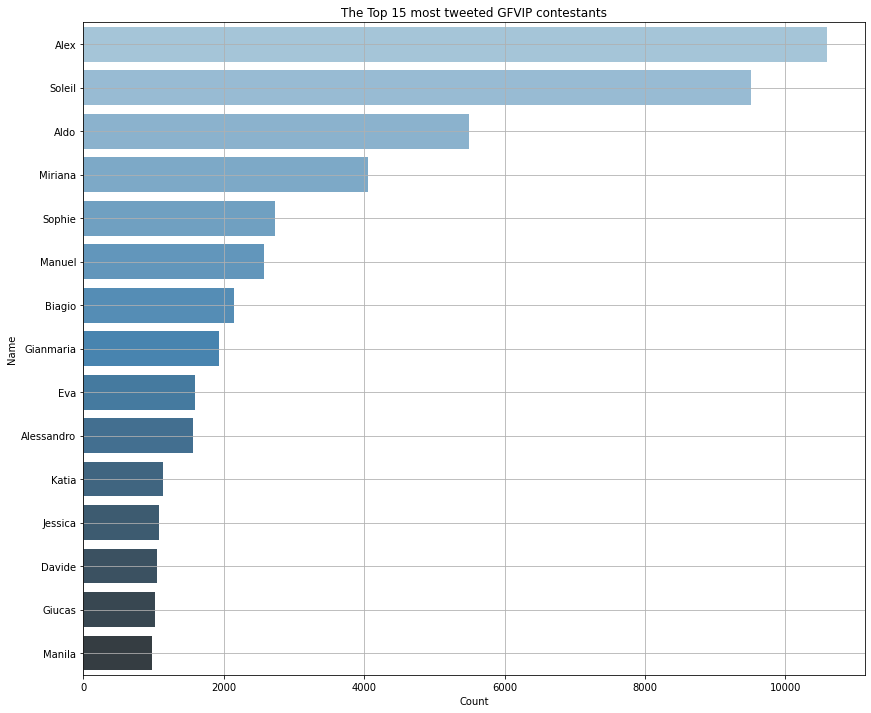

+-------+-----+
|   Name|Count|
+-------+-----+
|Alfonso| 2252|
|  Sonia|  759|
|Adriana|  404|
+-------+-----+



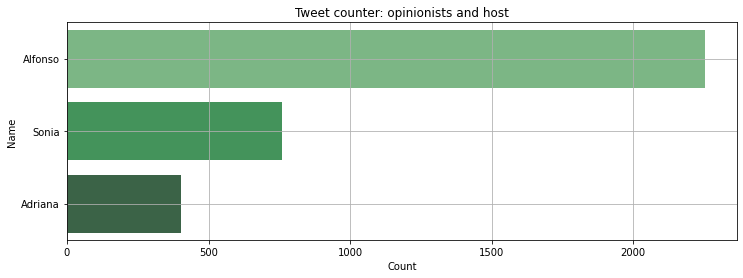

In [ ]:
print_timedelta(start)

# Tweet analysis of the contestants
tweet_analysis(query_tweet_contestants, fig_cont_frid, palette="Blues_d",
               title="The Top 15 most tweeted GFVIP contestants")

# Tweet analysis of the opinionist and the host
tweet_analysis(query_tweet_opinionists, fig_opin_frid, figsize=(12,4), palette="Greens_d", 
               title="Tweet counter: opinionists and host")

In [ ]:
#ssc.stop()
#!sudo kill $(sudo lsof -t -i:9999)

### Tweet analysis - Monday, December 20

Start tweet analysis: 2021-12-20 21:28:45
Last update: 2021-12-21 01:39:55
Elapsed time: 4 hours, 11 minutes, 10 seconds
+----------+-----+
|      Name|Count|
+----------+-----+
|    Soleil| 8517|
|      Alex| 7346|
|      Aldo| 3469|
|      Lulù| 2433|
|   Miriana| 2163|
|    Manuel| 2006|
|Alessandro| 1900|
|   Giacomo| 1370|
|       Eva| 1350|
|   Jessica| 1283|
|    Carmen| 1252|
|   Valeria| 1041|
|    Sophie| 1026|
|    Biagio| 1010|
| Gianmaria| 1006|
+----------+-----+



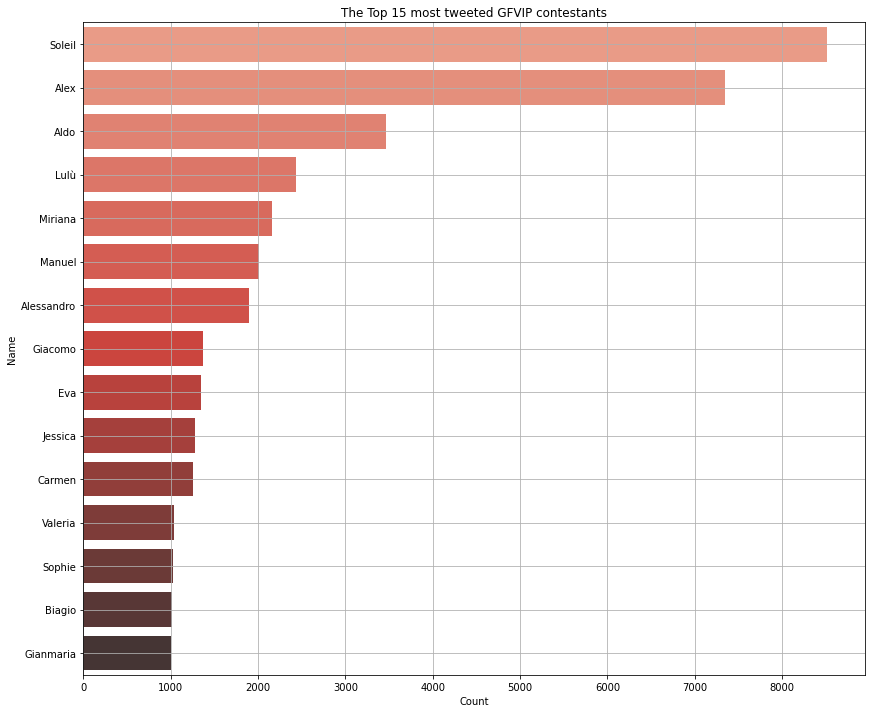

+-------+-----+
|   Name|Count|
+-------+-----+
|  Sonia|10124|
|Alfonso| 4837|
|Adriana| 1827|
+-------+-----+



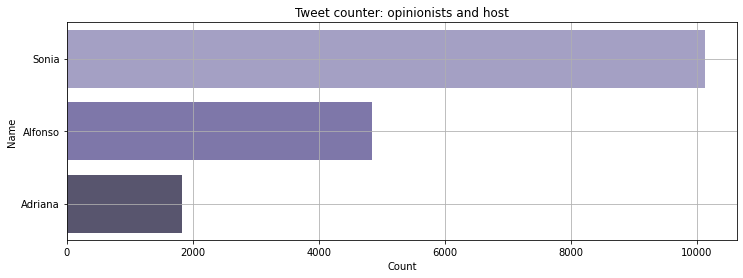

In [ ]:
print_timedelta(start)

# Tweet analysis of the contestants
tweet_analysis(query_tweet_contestants, fig_cont_mond, palette="Reds_d",
               title="The Top 15 most tweeted GFVIP contestants")

# Tweet analysis of the opinionist and the host
tweet_analysis(query_tweet_opinionists, fig_opin_mond, figsize=(12,4), palette="Purples_d", 
               title="Tweet counter: opinionists and host")

In [ ]:
#ssc.stop()
#!sudo kill $(sudo lsof -t -i:9999)